In [1]:
import time
print(time.ctime())

Thu Mar 28 22:37:42 2024


<sub>Bei diesem IPython-Notebook handelt es sich um eine Beispiel-Rechnung als Ergänzung zur Dissertationsschrift von C. Knoll. Allgemeine Hinweise zu den Beispielen sind in der [readme.md-Datei des entsprechenden Repositoriums](https://github.com/cknoll/beispiele/blob/master/readme.md) zu finden.</sub>

---

[//]: # (custom_config_start)
$$
\newcommand{\col}{\mathrm{col}}
\newcommand{\opspan}{\operatorname{span}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\mb}{\mathbf}
\newcommand{\nx}{n_{\boldsymbol x}}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
$$

[//]: # (custom_config_end)

**Betrachtetes System**: unteraktuierten Zweigelenkmanipulator.<br>

<img src="files/images/manipulator_def2.png">

**Betrachtete Fragen**:
* Herleitung der Modellgleichungen
 * Zustandsdarstellung zum Eingang $\bs \tau$
 * partiell linearisiert
 * LBI-NF 

* Überprüfung verschiedener Steuerbarkeitsbedingungen
 * Steuerbarkeit der Linearisierung um eine Ruhelage !!
 * lokale Zugänglichkeit
 * starke lokale Zugänglichkeit


In [2]:
%load_ext ipydex.displaytools

import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix
import ipydex


printing.init_printing(1)

In [3]:
t = sp.Symbol('t')
np = 1
nq = 1
n = np + nq
pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))


aa = st.symb_vector("a1:{0}".format(nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

---

---

---

In [4]:
params = sp.symbols('s1, s2, m1, m2, J1, J2, l1, kappa')
st.make_global(params)

tau1, tau2 = ttau = st.symb_vector("tau1, tau2")

### Festlegung der Geometrie des mechanischen Systemes

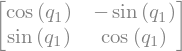

In [5]:
Rz(q1) # Rotationsmatirx

In [6]:
#Einheitsvektoren

ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# Koordinaten der Schwerpunkte und Gelenke
S1 = Rz(q1)*ex*s1
G1 = Rz(q1)*ex*l1 # "Elllenbogengelenk"
S2 = G1 + Rz(q1 + p1)*ex*s2


# Zeitableitungen der Schwerpunktskoordinaten
Sd1, Sd2 = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##

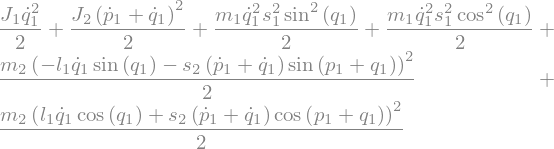

---

In [7]:
# Kinetische Energie
T_rot = (J1*qdot1**2)/2 + (J2*(qdot1 + pdot1)**2)/2
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 )/2

T = T_rot + T_trans[0] ##:

# Potentielle Energie
V = 0

In [8]:
# Kinetische Energie mit Platzhaltersymbolen einführen:

M1, M2, M3 = MM = st.symb_vector('M1:4')
MM_subs = [(J1 + m1*s1**2 + m2*l1**2, M1), (J2 + m2*s2**2, M2), (m2*l1*s2, M3)]
MM_rplm = st.rev_tuple(MM_subs) # Umkehrung der inneren Tupel -> [(M1, J1+... ), ...]

T_plh = M1*qdot1**2/2 + M2*pdot1**2/2 + M2*pdot1*qdot1 + M2*qdot1**2/2 + M3*pdot1*qdot1*cos(p1) + M3*qdot1**2*cos(p1)

# Probe:
assert sp.simplify(T_plh.subs(MM_rplm) - T) == 0

In [9]:
# neu: tau2 nutzen um später Reibung zu modellieren


external_forces = [tau2, tau1]
# assert not any(external_forces[:np])
mod = mt.generate_symbolic_model(T_plh, V, ttheta, external_forces)

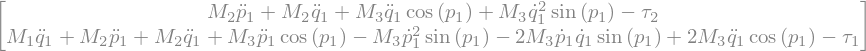

In [10]:
mod.eqns 

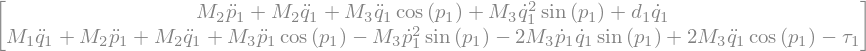

---

In [11]:
# Reibung einführen:
d1 = sp.Symbol("d1")
mod.eqns = mod.eqns.subs(tau2, - qdot1*d1) ##:
mod.tau = sp.Matrix([tau1])

### Verschiedene Zustandsdarstellungen
#### Vektorfelder der Zustandsdarstellung mit Eingang $\bs \tau$

In [12]:
mod.calc_state_eq()

In [13]:
# Symbole für Geschwindigkeiten
tthetad_replm = zip(tthetad, st.symb_vector('u1, v1'))

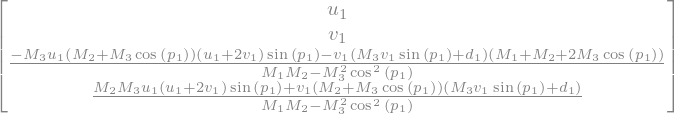

---

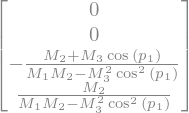

---

In [14]:
f = mod.f.subs(tthetad_replm) ##:
g = mod.g.subs(tthetad_replm) ##:

In [15]:
# Zustandsvektor
xx = mod.xx ##:T

---

#### Vektorfelder der kollokierten partiellen Linearisierung

In [16]:
def failing_function():
    mod.calc_coll_part_lin_state_eq()

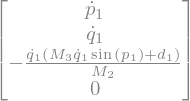

---

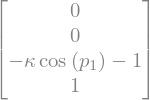

In [17]:
mod.calc_coll_part_lin_state_eq()
kappa_subs = M3/M2 # l1*s2*m2/(J2+m2*s2**2)

ff = mod.ff.subs(kappa_subs, kappa) ##:
gg = mod.gg.expand().subs(kappa_subs, kappa)
gg ##

## Umrechnen auf-nicht kollokierte partielle Linearisierung 

Ausgang: passives Gelenk, also $y:= p_1$, $\ddot y =: v_2$

In [18]:
v2 = sp.Symbol("v2")

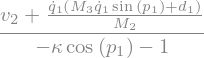

---

In [19]:
# Eingangstransformation

v1 = 1/gg[2] *(- ff[2] + v2) ##:

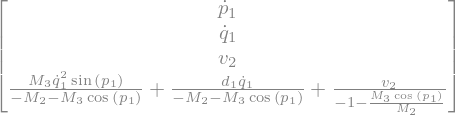

---

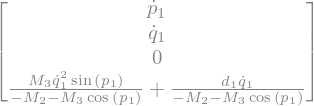

---

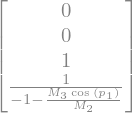

---

In [20]:
ode_new = (ff + gg*v1).expand().subs(kappa, M3/M2) ##:

ff2 = ode_new.subs(v2, 0) ##:
gg2 = ode_new.diff(v2) ##:





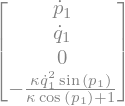

In [21]:
# Vergleich mit reibungsfreier Darstellung in Diplomarbeit (Knoll 2009) (mit Notation kappa := eta)
ff2.subs([(d1, 0), (M3, kappa*M2)]).smplf

### Untersuchung der Nulldynamik

linearer Teil: $p_1$ soll konstant sein → $v_2 = 0$

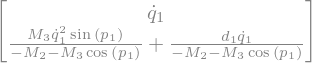

---

In [22]:
ff_nd = sp.Matrix([ff2[1], ff2[3]]) ##:

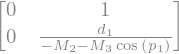

---

In [23]:
# Linearisierung: Ableiten nach Zustandskomponenten der Nulldynamik und Nullsetzen

jac_nd = ff_nd.jacobian([q1, qdot1]).subz0([q1, qdot1]) ##:


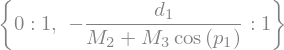

In [24]:
jac_nd.eigenvals()

**Fazit:** Ein Eigenwert is bei 0 der anderer hängt vom "gennullten Ausgang $p_1$" ab und könnte somit in die rechte Halbebene verschoben werden (für den Fall einer schwachen Trägheitskopplung, also $\kappa > 1$). 